In [5]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


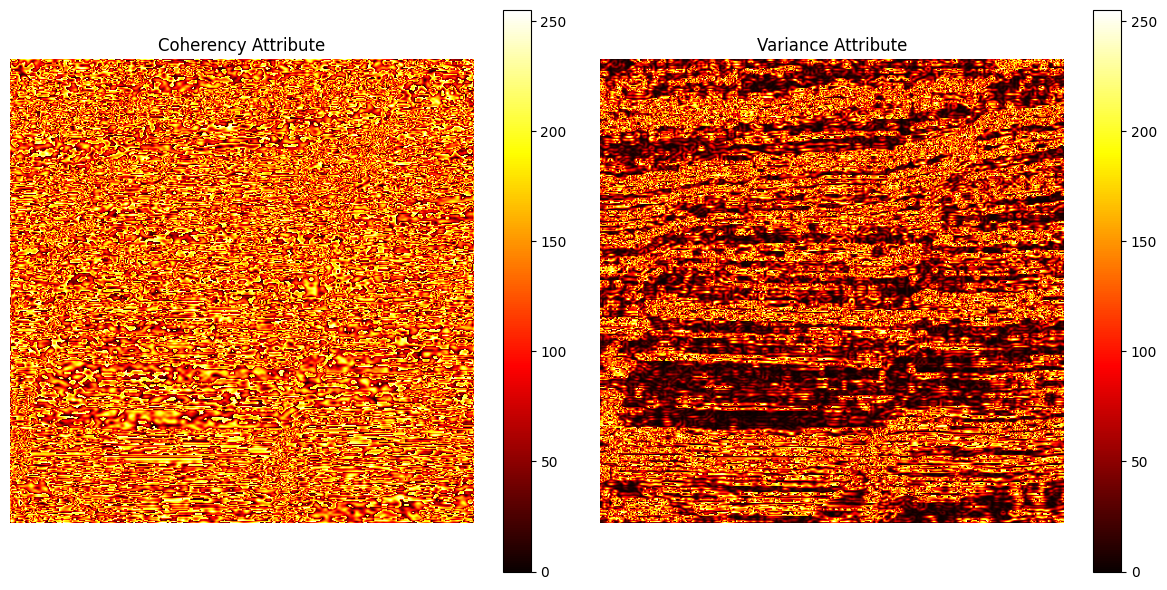

In [32]:
import scipy.ndimage as ndi
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter

# Define a function to compute semblance (coherency) over a window
def compute_coherency(image_data, window_size=3):
    coherence = ndi.correlate(image_data, np.ones((window_size, window_size)), mode='constant')
    return coherence

# Define a function to compute variance over a window
def compute_variance(image_data, window_size):
    return generic_filter(image_data, np.var, size=(window_size, window_size))

# Load the PNG image
image_path = 'seismic-1240_1240_398_0.png'  # Replace with your image path
image = Image.open(image_path).convert('L')  # Convert to grayscale
seismic_data = np.array(image)  # Convert to NumPy array

# Compute coherency and variance attributes
coherency_output = compute_coherency(seismic_data, window_size=3)
variance_output = compute_variance(seismic_data, window_size=3)

# Display the results
plt.figure(figsize=(12, 6))

# Coherency attribute
plt.subplot(1, 2, 1)
plt.imshow(coherency_output, cmap='hot')
plt.colorbar()
plt.title('Coherency Attribute')
plt.axis('off')

# Variance attribute
plt.subplot(1, 2, 2)
plt.imshow(variance_output, cmap='hot')
plt.colorbar()
plt.title('Variance Attribute')
plt.axis('off')

plt.tight_layout()
plt.show()


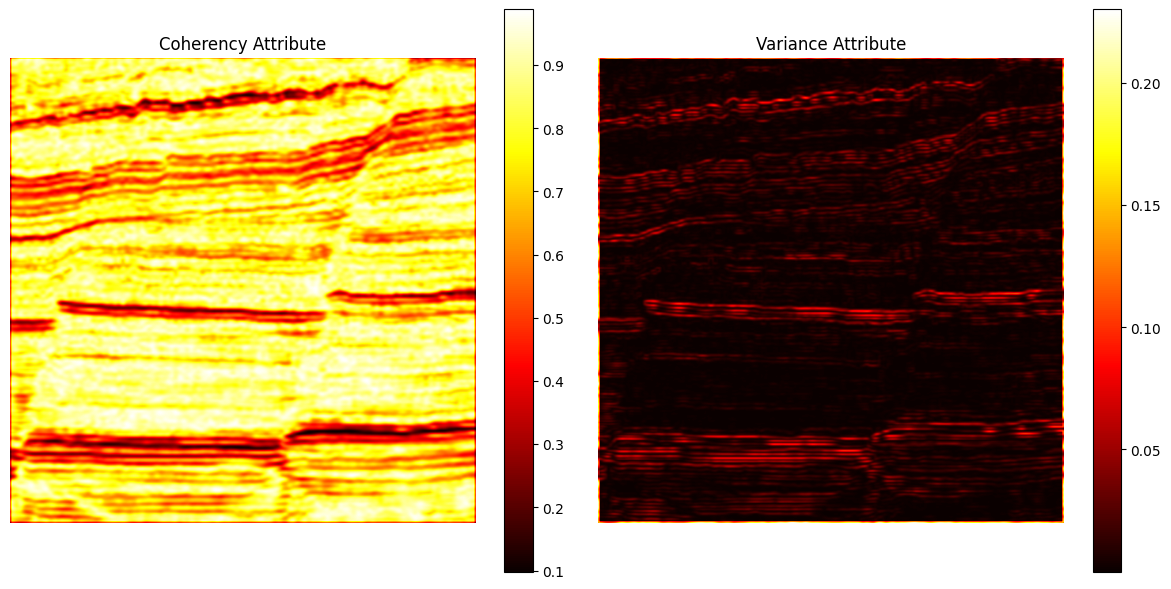

In [33]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the seismic image using OpenCV
image_path = 'seismic-1240_1240_398_0.png'  # Replace with your image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
image_tensor = torch.tensor(image, dtype=torch.float32)  # Convert to PyTorch tensor

# Normalize the image tensor
image_tensor = image_tensor / 255.0  # Scale values to [0, 1]

# Define a function for coherency (mean over a window)
def compute_coherency(image_tensor, window_size=5):
    kernel = torch.ones((1, 1, window_size, window_size), dtype=torch.float32) / (window_size**2)
    kernel = kernel.to(image_tensor.device)
    image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    coherence = torch.nn.functional.conv2d(image_tensor, kernel, padding=window_size // 2)
    return coherence.squeeze(0).squeeze(0)  # Remove batch and channel dimensions

# Define a function for variance (local variance over a window)
def compute_variance(image_tensor, window_size=5):
    kernel = torch.ones((1, 1, window_size, window_size), dtype=torch.float32)
    kernel = kernel.to(image_tensor.device)
    image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    
    # Compute local mean
    local_mean = torch.nn.functional.conv2d(image_tensor, kernel / kernel.sum(), padding=window_size // 2)
    
    # Compute local squared mean
    local_mean_square = torch.nn.functional.conv2d(image_tensor**2, kernel / kernel.sum(), padding=window_size // 2)
    
    # Compute variance = E[X^2] - (E[X])^2
    local_variance = local_mean_square - (local_mean**2)
    return local_variance.squeeze(0).squeeze(0)  # Remove batch and channel dimensions

# Compute coherency and variance
coherency_output = compute_coherency(image_tensor, window_size=5)
variance_output = compute_variance(image_tensor, window_size=5)

# Convert results back to NumPy for visualization
coherency_output_np = coherency_output.detach().cpu().numpy()
variance_output_np = variance_output.detach().cpu().numpy()

# Plot the results
plt.figure(figsize=(12, 6))

# Coherency attribute
plt.subplot(1, 2, 1)
plt.imshow(coherency_output_np, cmap='hot')
plt.colorbar()
plt.title('Coherency Attribute')
plt.axis('off')

# Variance attribute
plt.subplot(1, 2, 2)
plt.imshow(variance_output_np, cmap='hot')
plt.colorbar()
plt.title('Variance Attribute')
plt.axis('off')

plt.tight_layout()
plt.show()


In [34]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1. Dataset Preparation
class SeismicDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Normalize the image
        image = torch.tensor(image / 255.0, dtype=torch.float32).unsqueeze(0)  # Add channel
        mask = torch.tensor(mask / 255.0, dtype=torch.float32).unsqueeze(0)   # Add channel
        return image, mask

# 2. U-Net Model Definition
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 3. Training and Evaluation Function
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

    return model

# 4. Main Script
if __name__ == "__main__":
    # Load seismic images and masks (replace with your dataset paths)
    image_path = 'seismic-1240_1240_398_0.png'
    mask_dir = "path_to_masks"

    images = [cv2.imread(os.path.join(image_dir, img), cv2.IMREAD_GRAYSCALE) for img in os.listdir(image_dir)]
    masks = [cv2.imread(os.path.join(mask_dir, mask), cv2.IMREAD_GRAYSCALE) for mask in os.listdir(mask_dir)]

    # Split dataset into train and validation sets
    train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

    # Create PyTorch datasets and loaders
    train_dataset = SeismicDataset(train_images, train_masks)
    val_dataset = SeismicDataset(val_images, val_masks)
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model initialization
    model = UNet().to(device)

    # Train the model
    model = train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001)

    # Visualize results
    model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = outputs.cpu().numpy()

            # Show one result
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.title("Input Image")
            plt.imshow(images[0].cpu().numpy().squeeze(), cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title("Ground Truth Mask")
            plt.imshow(masks[0].cpu().numpy().squeeze(), cmap="gray")
            plt.subplot(1, 3, 3)
            plt.title("Predicted Fault Mask")
            plt.imshow(outputs[0].squeeze(), cmap="gray")
            plt.show()
            break


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_images'

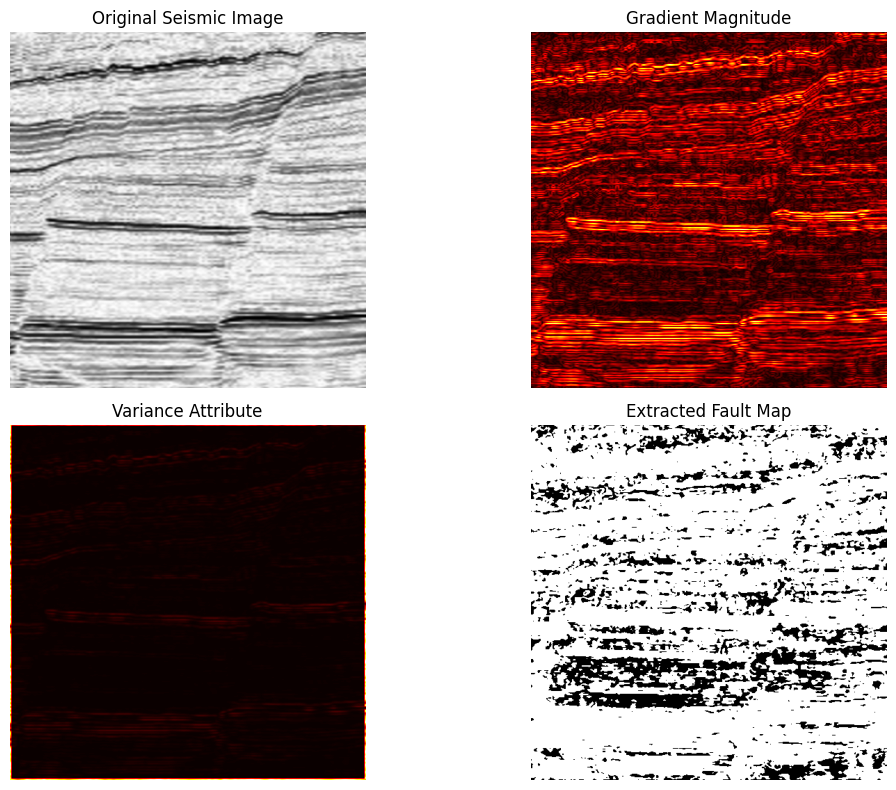

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# 1. Load the Seismic Image
image_path = 'seismic-1240_1240_398_0.png'  # Replace with your seismic image file
seismic_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Normalize the image
seismic_image = seismic_image.astype(np.float32) / 255.0

# 2. Apply a Gradient Operation to Highlight Discontinuities
# Sobel filter to compute gradients
sobel_x = cv2.Sobel(seismic_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(seismic_image, cv2.CV_64F, 0, 1, ksize=3)

# Gradient magnitude
gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

# 3. Optional: Apply Variance or Coherency as Seismic Attributes
# Variance computation in a sliding window
window_size = 5
variance_image = seismic_image.copy()
for i in range(window_size // 2, seismic_image.shape[0] - window_size // 2):
    for j in range(window_size // 2, seismic_image.shape[1] - window_size // 2):
        window = seismic_image[i - window_size // 2 : i + window_size // 2 + 1,
                               j - window_size // 2 : j + window_size // 2 + 1]
        variance_image[i, j] = np.var(window)

# 4. Postprocessing to Enhance Fault Lines
# Apply Gaussian smoothing
smoothed_gradient = gaussian_filter(gradient_magnitude, sigma=1)

# Thresholding to extract prominent features
_, fault_map = cv2.threshold(smoothed_gradient, 0.2, 1.0, cv2.THRESH_BINARY)

# 5. Visualization
plt.figure(figsize=(12, 8))

# Original Seismic Image
plt.subplot(2, 2, 1)
plt.title("Original Seismic Image")
plt.imshow(seismic_image, cmap="gray")
plt.axis("off")

# Gradient Magnitude
plt.subplot(2, 2, 2)
plt.title("Gradient Magnitude")
plt.imshow(gradient_magnitude, cmap="hot")
plt.axis("off")

# Variance Attribute
plt.subplot(2, 2, 3)
plt.title("Variance Attribute")
plt.imshow(variance_image, cmap="hot")
plt.axis("off")

# Fault Map
plt.subplot(2, 2, 4)
plt.title("Extracted Fault Map")
plt.imshow(fault_map, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


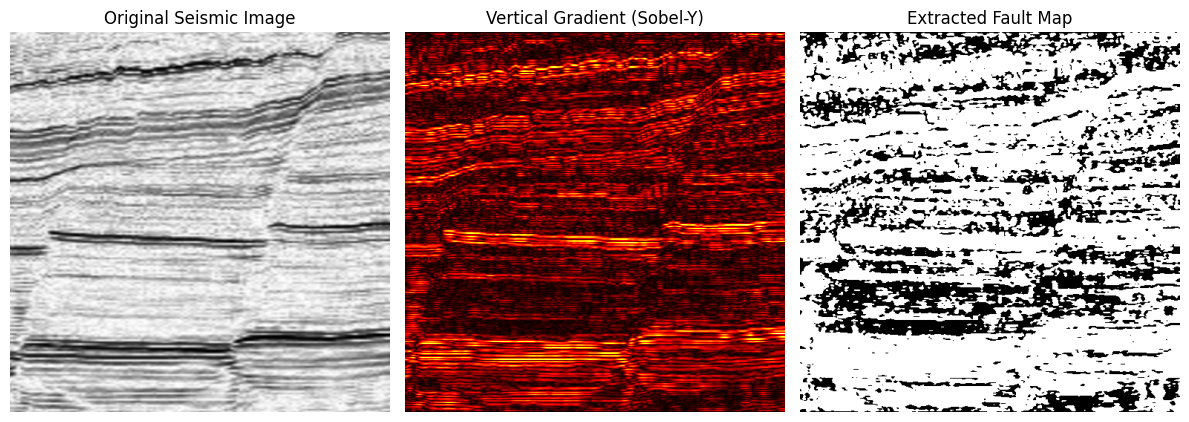

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# 1. Load the Seismic Image
image_path = 'seismic-1240_1240_398_0.png'  # Replace with your seismic image file
seismic_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Normalize the image
seismic_image = seismic_image.astype(np.float32) / 255.0

# 2. Apply a Vertical Filter
# Sobel filter for vertical changes (Y-axis gradient)
sobel_vertical = cv2.Sobel(seismic_image, cv2.CV_64F, 0, 1, ksize=3)

# Optional: Compute the absolute value to ignore direction
vertical_gradient = np.abs(sobel_vertical)

# 3. Postprocessing to Enhance Fault Features
# Apply Gaussian smoothing to reduce noise
smoothed_gradient = gaussian_filter(vertical_gradient, sigma=1)

# Thresholding to extract prominent vertical features
_, fault_map = cv2.threshold(smoothed_gradient, 0.2, 1.0, cv2.THRESH_BINARY)

# 4. Visualization
plt.figure(figsize=(12, 6))

# Original Seismic Image
plt.subplot(1, 3, 1)
plt.title("Original Seismic Image")
plt.imshow(seismic_image, cmap="gray")
plt.axis("off")

# Vertical Gradient (Sobel-Y)
plt.subplot(1, 3, 2)
plt.title("Vertical Gradient (Sobel-Y)")
plt.imshow(vertical_gradient, cmap="hot")
plt.axis("off")

# Fault Map
plt.subplot(1, 3, 3)
plt.title("Extracted Fault Map")
plt.imshow(fault_map, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


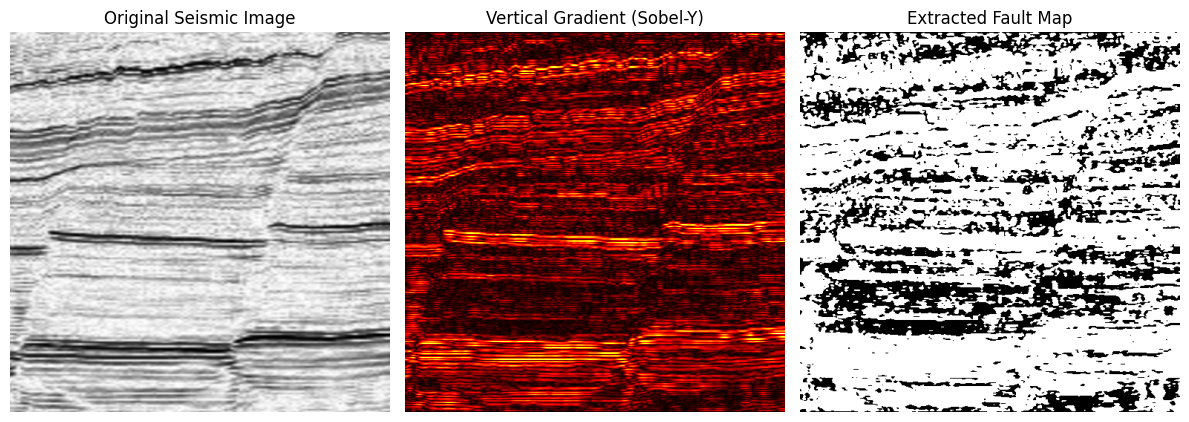

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# 1. Load the Seismic Image
# image_path = 'seismic_image.png'  # Replace with your seismic image file
seismic_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Normalize the image
seismic_image = seismic_image.astype(np.float32) / 255.0

# 2. Apply a Vertical Filter
# Sobel filter for vertical changes (Y-axis gradient)
sobel_vertical = cv2.Sobel(seismic_image, cv2.CV_64F, 0, 1, ksize=3)

# Optional: Compute the absolute value to ignore direction
vertical_gradient = np.abs(sobel_vertical)

# 3. Postprocessing to Enhance Fault Features
# Apply Gaussian smoothing to reduce noise
smoothed_gradient = gaussian_filter(vertical_gradient, sigma=1)

# Thresholding to extract prominent vertical features
_, fault_map = cv2.threshold(smoothed_gradient, 0.2, 1.0, cv2.THRESH_BINARY)

# 4. Visualization
plt.figure(figsize=(12, 6))

# Original Seismic Image
plt.subplot(1, 3, 1)
plt.title("Original Seismic Image")
plt.imshow(seismic_image, cmap="gray")
plt.axis("off")

# Vertical Gradient (Sobel-Y)
plt.subplot(1, 3, 2)
plt.title("Vertical Gradient (Sobel-Y)")
plt.imshow(vertical_gradient, cmap="hot")
plt.axis("off")

# Fault Map
plt.subplot(1, 3, 3)
plt.title("Extracted Fault Map")
plt.imshow(fault_map, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()
